In [100]:
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.svm import SVC,SVR
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# Set some properties of the model. We'll store these in a dict so they're
# easier to pass around or save.
model = {}

# properties of the recurrent pool:
model['N']      = 1000                 # number of neurons
model['g']      = 0.95                 # gain of synaptic weights in pool
model['sp']     = 0.25                 # fraction of weights that are nonzero
model['tau']    = 20                   # neural membrane time constant in ms
model['dt']     = 0.1                  # simulation timestep in ms
model['nonlin'] = lambda x: np.tanh(x) # firing rate nonlinearity for pool units

# properties of the input layer:
# a note: we're going to encode the "value" of the input by the identity of the
# active input layer units. We'll use one-hot encoding: for each input step
# during simulation, one unit will be activated with "firing rate" 1, and the
# rest will be set to firing rate 0 (adjust gIn to change the scaling of input
# to the recurrent pool.)
# Note 1: This is just one way of setting up input- are there other approaches
# that would improve memory capacity?
# Note 2: Burn-in time is especially important if your model has g>1, in which
# case neurons will be spontaneously active.
model['nIn']    = 20                   # size of the input layer
model['gIn']    = 10.0                 # gain of the input weights
model['spIn']   = 0.05                 # sparsity of input->pool connectivity
model['burnIn'] = 10                   # time before input starts
model['durIn']  = 1                    # time for which an input is active in ms
model['ISI']    = 0                    # time between inputs in ms
model['nonlinIn'] = lambda x: x        # best to keep the input linear

In [3]:
# Create the synaptic weight matrix.
# Normalizing weights by sqrt(N*sparsity) keeps the eigenvalue spectrum
# invariant to the size of the population N.
randMat      = np.random.normal(0, 1, size=(model['N'], model['N']))
spMat        = np.random.uniform(0, 1, size=(model['N'], model['N'])) \
                <= model['sp']
model['J']   = np.multiply(randMat, spMat) \
                * model['g'] / math.sqrt(model['N'] * model['sp'])

# Create the input weight matrix.
randMatIn    = np.random.normal(0, 1, size=(model['N'], model['nIn']))
spMatIn      = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) \
                <= model['spIn']
model['Jin'] = np.multiply(randMatIn, spMatIn) \
                * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

In [4]:
spMatIn

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [5]:
# Define a couple helper functions for simulation.

def step(firing_rates, input_layer, model):
    # The simulation function. We use Euler's method to simulate the evolution of
    # model neuron firing rates given the input_layer firing rates.
  
    timestep = math.exp(-model['dt']/model['tau'])
    #Calculate the input values
    #1000*1000,1000*1->1000*1;1000*20,20*1->1000:1
    vIn = np.matmul(model['J'], firing_rates) \
    + np.matmul(model['Jin'], model['nonlinIn'](input_layer))
    #Update the firing rate
    updated_rates = model['nonlin'](vIn + (firing_rates - vIn) * timestep)

    return updated_rates


def make_input(sequence_length, model):
  # Generates a sequence of inputs according to the parameters in model. Returns
  # the sequence both as a one-hot encoding and as a sequence of integer values.

  input_stream = [0] * int(model['burnIn']/model['dt'])

  for i in range(sequence_length):
    val = np.random.randint(0, model['nIn']) + 1
    for t in range(int(model['ISI']/model['dt'])):
      input_stream.append(0.0)
    for t in range(int(model['durIn']/model['dt'])):
      input_stream.append(val)
    
  input_stream = np.array(input_stream)

  onehot = np.zeros((model['nIn']+1, input_stream.size))
  onehot[input_stream, np.arange(input_stream.size)] = 1.0
  onehot = onehot[1:,:]

  return onehot, input_stream

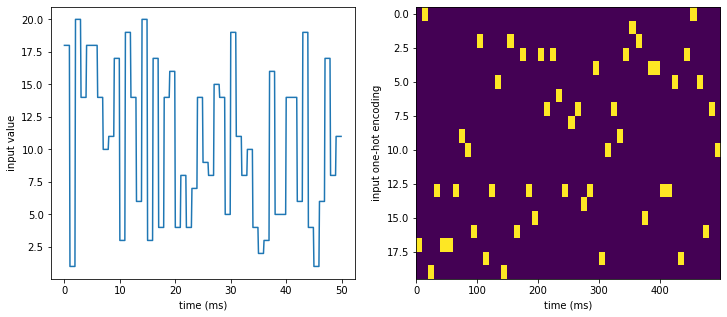

In [6]:
# Look at an example input stream.

onehot, stream = make_input(50, model)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
omit = int(model['burnIn']/model['dt']) # don't plot the burn-in period
ax[0].plot(np.arange(len(stream) - omit) * model['dt'], stream[omit:]);
ax[0].set_xlabel('time (ms)');
ax[0].set_ylabel('input value');

ax[1].imshow(onehot[:, omit:], aspect='auto');
ax[1].set_xlabel('time (ms)');
ax[1].set_ylabel('input one-hot encoding');

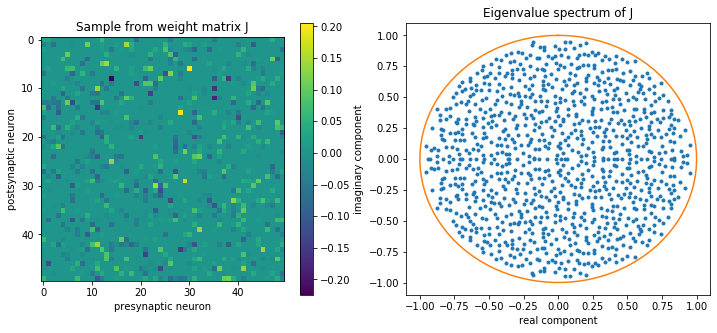

In [7]:
# Take a look at the eigenvalue spectrum of J.
w, v = np.linalg.eig(model['J'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
showCount = 50  # portion of J to actually show (for readability)
h=ax[0].imshow(model['J'][:showCount,:showCount]);
ax[0].set_title('Sample from weight matrix J');
ax[0].set_xlabel('presynaptic neuron');
ax[0].set_ylabel('postsynaptic neuron');
plt.colorbar(h, ax=ax[0]);

ax[1].plot(np.real(w),np.imag(w),'.');
ax[1].plot(np.sin(np.linspace(0,2*math.pi,100)),
           np.cos(np.linspace(0,2*math.pi,100))); # circle with radius 1
ax[1].set_title('Eigenvalue spectrum of J')
ax[1].set_xlabel('real component');
ax[1].set_ylabel('imaginary component');

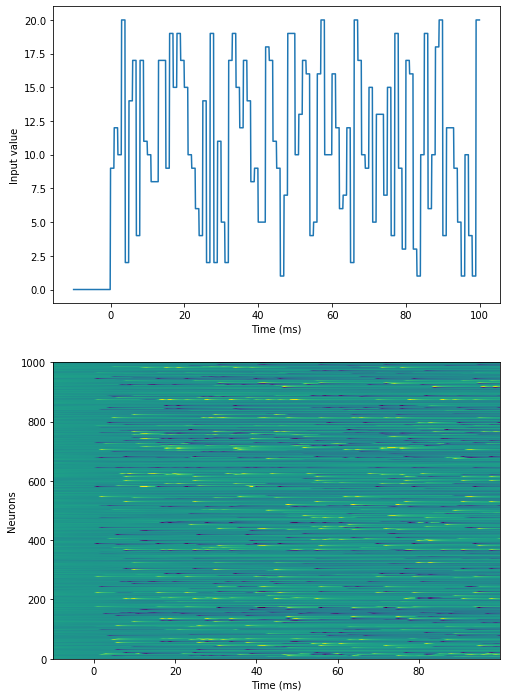

In [8]:
# Simulate the model activity.

# generate the input to the model
onehot, input_stream = make_input(100, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
    firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)


fig, ax = plt.subplots(2, 1, figsize=(8, 12))
simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
ax[0].plot(simulation_time, input_stream);
ax[0].set_xlabel('Time (ms)');
ax[0].set_ylabel('Input value');

extents = [simulation_time[0],simulation_time[-1], 0, model['N']]
ax[1].imshow(firing_rates, aspect='auto', extent=extents);
ax[1].set_xlabel('Time (ms)');
ax[1].set_ylabel('Neurons');

Now: can you decode the model's input history from its firing rates?

In [9]:
#number of trials
num=1500;
#the place to save all input values
firing_rates = np.zeros([model['N'], len(input_stream), num])
input_values=np.zeros([len(input_stream),num])

In [10]:
for i in range(num):
    # Simulate the model activity.

    # generate the input to the model
    onehot, input_stream = make_input(100, model)
    
    # i
    input_values[:,i]=input_stream;
    
    firing_rates[:, 0, i] = np.random.uniform(0, 0.1, size=(model['N']))

    for t in range(len(input_stream)-1):
        firing_rates[:,t+1,i] = step(firing_rates[:,t,i], onehot[:,t], model)

In [137]:
firing_rates.shape

(1000, 1100, 1500)

In [154]:
X_train=firing_rates[:,:,0];
y_train=input_values[:,0];

In [155]:
X_train.shape

(1000, 1100)

In [156]:
y_train.shape

(1100,)

In [157]:
LogisticsModel=linear_model.LogisticRegression(penalty='l2',C=1,max_iter=2000,solver='lbfgs',multi_class='multinomial')
LogisticsModel.fit(X_train.T,y_train)

LogisticRegression(C=1, max_iter=2000, multi_class='multinomial')

In [158]:
y_pred=LogisticsModel.predict(firing_rates[:,:,1].T)

In [159]:
y_pred

array([ 0.,  0.,  0., ..., 15., 15., 15.])

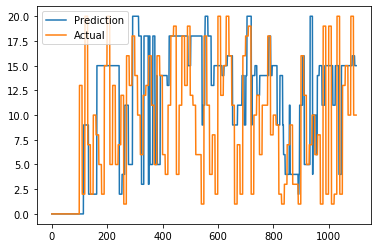

In [161]:
plt.figure()
plt.plot(y_pred)
plt.plot(input_values[:,1])
plt.legend(['Prediction','Actual'])

In [11]:
#Here, we take tstep=250
ts=250;

In [12]:
#Remove the burnIn time
X=firing_rates[:,ts,:];
y=input_values[ts,:];

X=X.T;


print(X.shape)
print(y.shape)

(1500, 1000)
(1500,)


In [13]:
#Decoder 1:Linear Regression

In [67]:
#The whole timespan
LinearModel=linear_model.LinearRegression()
LinearModel.fit(X,y)

LinearRegression()

In [68]:
#Take t=ts-1 for prediction
y_pred=LinearModel.predict(firing_rates[:,ts-1,:].T)

In [69]:
y_pred

array([11.87517033, 17.04049936,  6.77117326, ..., 16.80130781,
        8.21966377, 12.97617053])

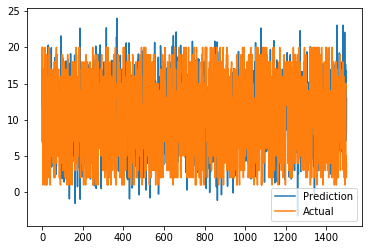

In [70]:
plt.figure()
plt.plot(y_pred)
plt.plot(input_values[ts-1,:])
plt.legend(['Prediction','Actual'])

In [71]:
#Consider time before 20 second
mse1=np.zeros(20)
for i in range(1,21):
    y_pred=LinearModel.predict(firing_rates[:,ts-i,:].T)
    y_actual=input_values[ts-i,:]
    mse1[i-1]=mean_squared_error(y_pred,y_actual)

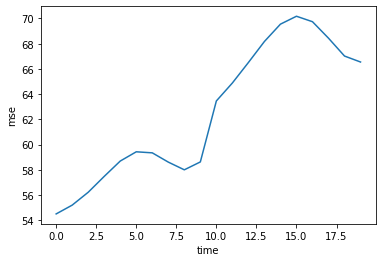

In [72]:
plt.figure()
plt.plot(mse1);
plt.xlabel('time')
plt.ylabel('mse')
plt.show()

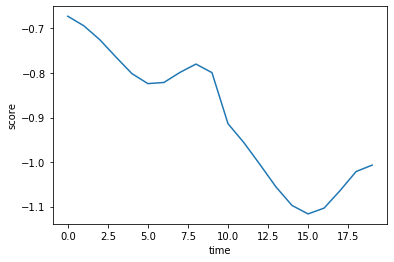

In [73]:
#Consider time before 20 second
score1=np.zeros(20)
for i in range(1,21):
    score1[i-1]=LinearModel.score(firing_rates[:,ts-i,:].T,input_values[ts-i,:])

plt.figure()
plt.plot(score1);
plt.xlabel('time')
plt.ylabel('score')
plt.show()

In [20]:
#Decoder 2:Logistics Regression

In [64]:
#The whole timespan
LogisticsModel=linear_model.LogisticRegression(penalty='l2',C=0.2,solver='lbfgs',multi_class='multinomial')
LogisticsModel.fit(X,y)

LogisticRegression(C=0.2, multi_class='multinomial')

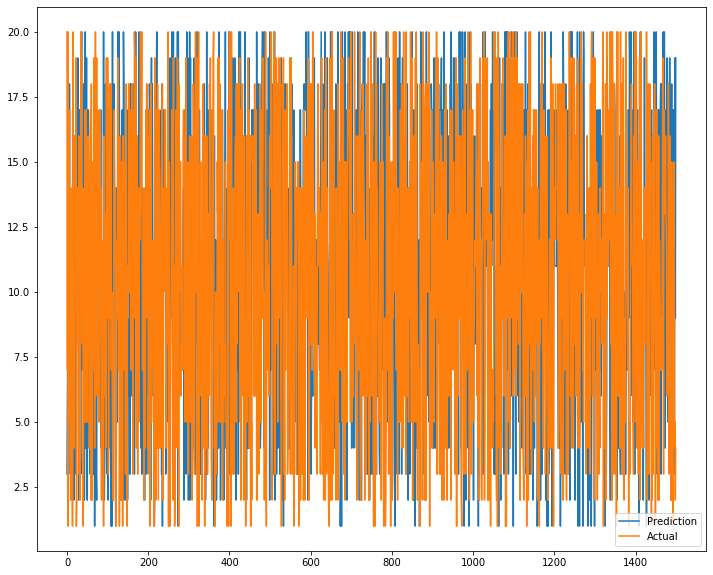

In [65]:
#Take t=ts-1 for prediction
y_pred=LogisticsModel.predict(firing_rates[:,ts-1,:].T)

plt.figure(figsize=[12,10])
plt.plot(y_pred)
plt.plot(input_values[ts-1,:])
plt.legend(['Prediction','Actual'])

In [66]:
y_pred

array([ 3.,  6.,  8., ..., 19.,  9., 19.])

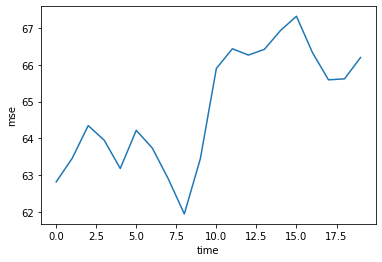

In [23]:
#Consider time before 20 second
mse2=np.zeros(20)
for i in range(1,21):
    y_pred=LogisticsModel.predict(firing_rates[:,ts-i,:].T)
    y_actual=input_values[ts-i,:]
    mse2[i-1]=mean_squared_error(y_pred,y_actual)

plt.figure()
plt.plot(mse2);
plt.xlabel('time')
plt.ylabel('mse')
plt.show()

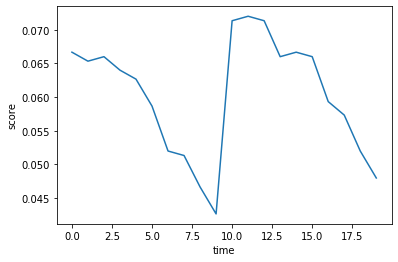

In [24]:
#Consider time before 20 second
score2=np.zeros(20)
for i in range(1,21):
    score2[i-1]=LogisticsModel.score(firing_rates[:,ts-i,:].T,input_values[ts-i,:])

plt.figure()
plt.plot(score2);
plt.xlabel('time')
plt.ylabel('score')
plt.show()

In [25]:
#Decoder 3:PoissonRegression

In [61]:
#The whole timespan
PoissonModel=linear_model.PoissonRegressor()
PoissonModel.fit(X,y)

PoissonRegressor()

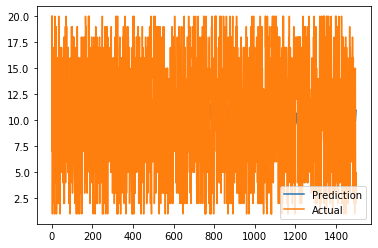

In [62]:
#Take t=ts-1 for prediction
y_pred=PoissonModel.predict(firing_rates[:,ts-1,:].T)

plt.figure()
plt.plot(y_pred)
plt.plot(input_values[ts-1,:])
plt.legend(['Prediction','Actual'])

In [63]:
y_pred

array([ 9.57735471, 10.29461125,  9.26633967, ..., 10.49898888,
       10.84807714, 10.9488206 ])

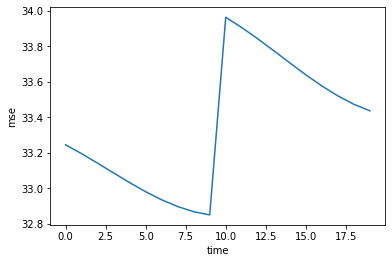

In [28]:
#Consider time before 20 second
mse3=np.zeros(20)
for i in range(1,21):
    y_pred=PoissonModel.predict(firing_rates[:,ts-i,:].T)
    y_actual=input_values[ts-i,:]
    mse3[i-1]=mean_squared_error(y_pred,y_actual)

plt.figure()
plt.plot(mse3);
plt.xlabel('time')
plt.ylabel('mse')
plt.show()

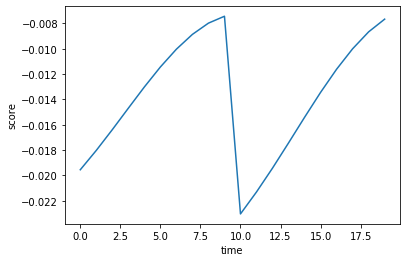

In [29]:
#Consider time before 20 second
score3=np.zeros(20)
for i in range(1,21):
    score3[i-1]=PoissonModel.score(firing_rates[:,ts-i,:].T,input_values[ts-i,:])

plt.figure()
plt.plot(score3);
plt.xlabel('time')
plt.ylabel('score')
plt.show()

In [87]:
#Decoder 4:Supported Vector Machine
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

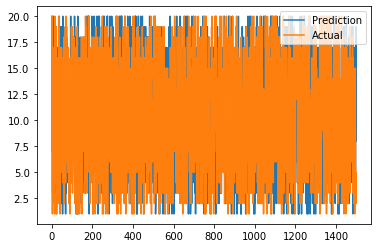

In [88]:
#Take t=ts-1 for prediction
y_pred=clf.predict(firing_rates[:,ts-1,:].T)

plt.figure()
plt.plot(y_pred)
plt.plot(input_values[ts-1,:])
plt.legend(['Prediction','Actual'])

In [89]:
input_values[ts-1,:]-y_pred

array([  3.,  -5.,  12., ..., -14.,  -6.,  -8.])

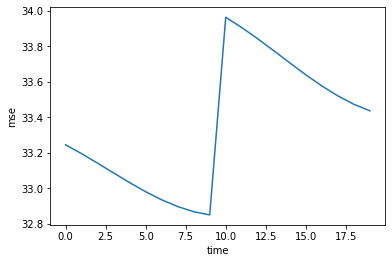

In [90]:
#Consider time before 20 second
mse4=np.zeros(20)
for i in range(1,21):
    y_pred=clf.predict(firing_rates[:,ts-i,:].T)
    y_actual=input_values[ts-i,:]
    mse4[i-1]=mean_squared_error(y_pred,y_actual)

plt.figure()
plt.plot(mse3);
plt.xlabel('time')
plt.ylabel('mse')
plt.show()

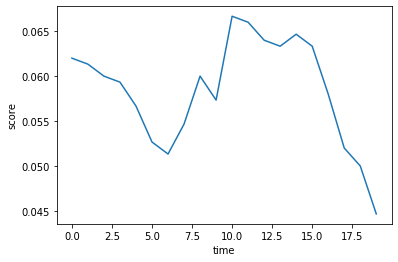

In [47]:
#Consider time before 20 second
score4=np.zeros(20)
for i in range(1,21):
    score4[i-1]=clf.score(firing_rates[:,ts-i,:].T,input_values[ts-i,:])

plt.figure()
plt.plot(score4);
plt.xlabel('time')
plt.ylabel('score')
plt.show()

In [48]:
#Decoder 5: Baynes Ridge
clf = linear_model.BayesianRidge(compute_score=True)
clf.fit(X, y)

BayesianRidge(compute_score=True)

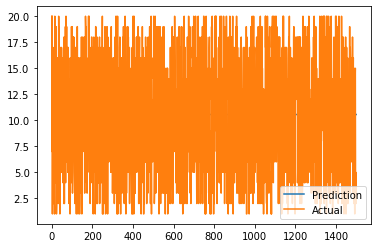

In [54]:
#Take t=ts-1 for prediction
y_pred=clf.predict(firing_rates[:,ts-1,:].T)

plt.figure()
plt.plot(y_pred)
plt.plot(input_values[ts-1,:])
plt.legend(['Prediction','Actual'])

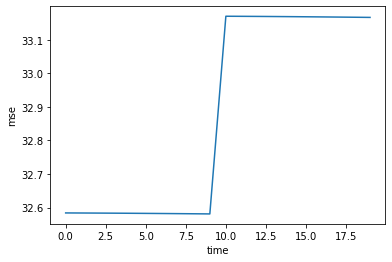

In [55]:
#Consider time before 20 second
mse5=np.zeros(20)
for i in range(1,21):
    y_pred=clf.predict(firing_rates[:,ts-i,:].T)
    y_actual=input_values[ts-i,:]
    mse5[i-1]=mean_squared_error(y_pred,y_actual)

plt.figure()
plt.plot(mse5);
plt.xlabel('time')
plt.ylabel('mse')
plt.show()

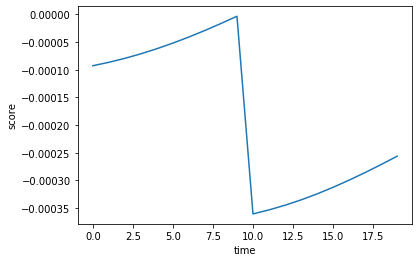

In [56]:
#Consider time before 20 second
score5=np.zeros(20)
for i in range(1,21):
    score5[i-1]=clf.score(firing_rates[:,ts-i,:].T,input_values[ts-i,:])

plt.figure()
plt.plot(score5);
plt.xlabel('time')
plt.ylabel('score')
plt.show()

In [95]:
#Decider 6:KNN
clf=KNeighborsClassifier()
clf.fit(X,y)

KNeighborsClassifier()

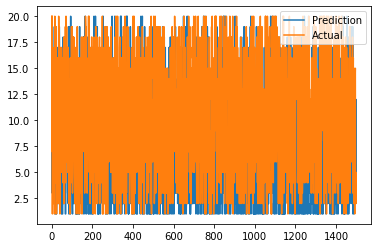

In [96]:
#Take t=ts-1 for prediction
y_pred=clf.predict(firing_rates[:,ts-1,:].T)

plt.figure()
plt.plot(y_pred)
plt.plot(input_values[ts-1,:])
plt.legend(['Prediction','Actual'])

In [98]:
y_pred

array([ 4.,  2., 16., ..., 19.,  8.,  6.])

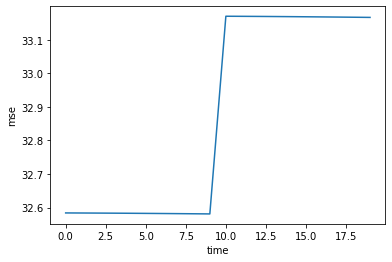

In [97]:
#Consider time before 20 second
mse6=np.zeros(20)
for i in range(1,21):
    y_pred=clf.predict(firing_rates[:,ts-i,:].T)
    y_actual=input_values[ts-i,:]
    mse6[i-1]=mean_squared_error(y_pred,y_actual)

plt.figure()
plt.plot(mse5);
plt.xlabel('time')
plt.ylabel('mse')
plt.show()

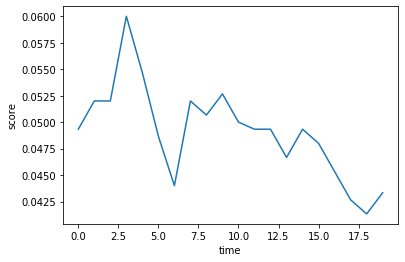

In [99]:
#Consider time before 20 second
score6=np.zeros(20)
for i in range(1,21):
    score6[i-1]=clf.score(firing_rates[:,ts-i,:].T,input_values[ts-i,:])

plt.figure()
plt.plot(score6);
plt.xlabel('time')
plt.ylabel('score')
plt.show()

In [101]:
#Decider 6:KNN
clf=LinearDiscriminantAnalysis()
clf.fit(X,y)

LinearDiscriminantAnalysis()

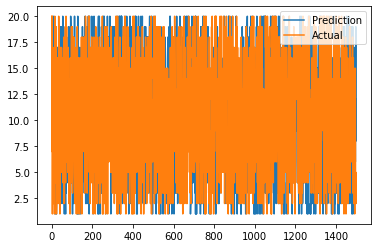

In [102]:
#Take t=ts-1 for prediction
y_pred=clf.predict(firing_rates[:,ts-1,:].T)

plt.figure()
plt.plot(y_pred)
plt.plot(input_values[ts-1,:])
plt.legend(['Prediction','Actual'])

In [103]:
y_pred

array([10., 12.,  7., ..., 19.,  8., 12.])

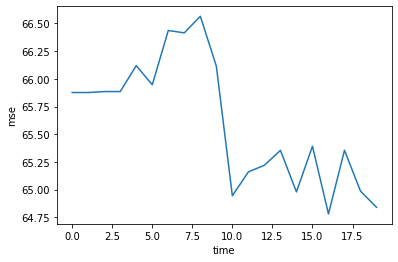

In [105]:
#Consider time before 20 second
mse7=np.zeros(20)
for i in range(1,21):
    y_pred=clf.predict(firing_rates[:,ts-i,:].T)
    y_actual=input_values[ts-i,:]
    mse7[i-1]=mean_squared_error(y_pred,y_actual)

plt.figure()
plt.plot(mse7);
plt.xlabel('time')
plt.ylabel('mse')
plt.show()

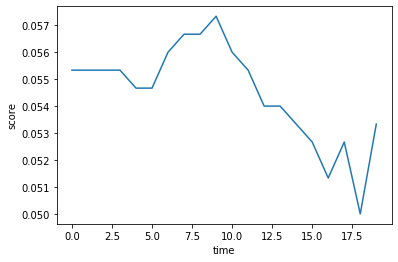

In [107]:
#Consider time before 20 second
score7=np.zeros(20)
for i in range(1,21):
    score7[i-1]=clf.score(firing_rates[:,ts-i,:].T,input_values[ts-i,:])

plt.figure()
plt.plot(score7);
plt.xlabel('time')
plt.ylabel('score')
plt.show()